<h1>2022.05.19. 강의 시간내 실습</h1>

In [19]:
import warnings

warnings.filterwarnings('ignore')

In [20]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt

In [22]:
(ds_train, ds_test), ds_info = tfds.load(
    'rock_paper_scissors',
    split=['train', 'test'],
    # shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [23]:
image_shape = ds_info.features['image'].shape
image_dtype = ds_info.features['image'].dtype

print(f'image shape: {image_shape}')
print(f'image dtype: {image_dtype}')

image shape: (300, 300, 3)
image dtype: <dtype: 'uint8'>


In [24]:
num_train = ds_info.splits['train'].num_examples
print(f'num of train: {num_train}')

# print(ds_test)
num_test = ds_info.splits['test'].num_examples
print(f'num of test : {num_test}')

num of train: 2520
num of test : 372


In [25]:
CLASS_NUM = ds_info.features['label'].num_classes # = 3
CLASS_NAMES = ['rock', 'paper', 'scissors']

print(f'num of class: {CLASS_NUM}\n')

for i in range(CLASS_NUM):
    print(i, CLASS_NAMES[i])

num of class: 3

0 rock
1 paper
2 scissors


scissors


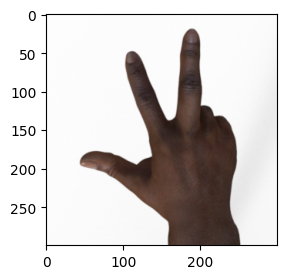

In [26]:
plt.figure(figsize=(3, 3))

for image, label in ds_train.take(1):
    plt.imshow(image)
    print(CLASS_NAMES[label.numpy()])

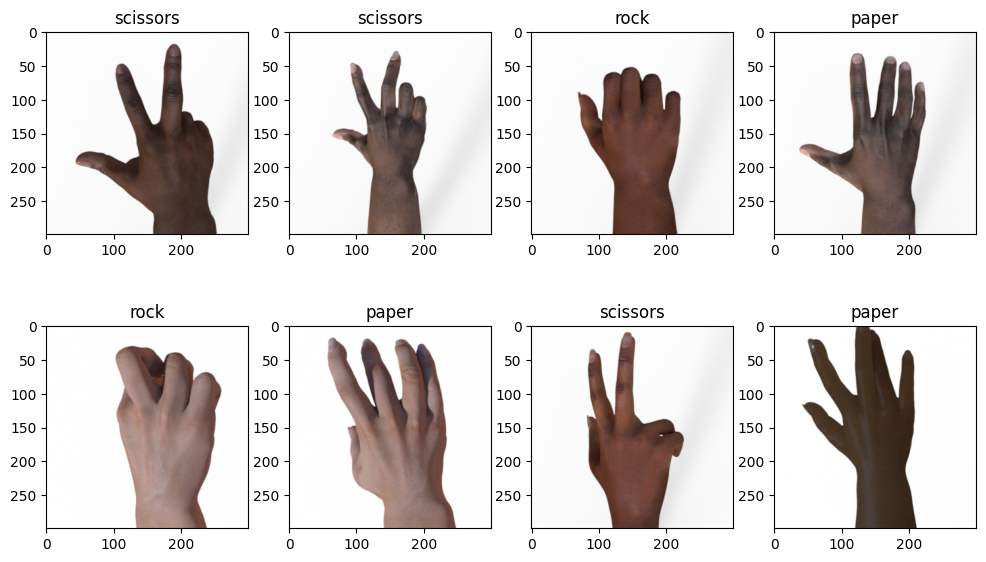

In [27]:
plt.figure(figsize=(12, 7))

i = 1
for image, label in ds_train.take(8):
    plt.subplot(2, 4, i)
    i += 1
    # plt.axis('Off')
    label = CLASS_NAMES[label.numpy()]
    plt.title(f'{label}')
    plt.imshow(image)

In [28]:
for image, label in ds_test.take(1):
    test_image0 = image.numpy()
    test_label0 = label.numpy()

In [29]:
INPUT_IMG_SIZE = 100

def normalize_img(image, label):
    # Make image color values to be float.
    image = tf.cast(image, tf.float32)
    # Make image color values to be in [0..1] range.
    image = image / 255.
    # Make sure that image has a right size
    image = tf.image.resize(image, [INPUT_IMG_SIZE, INPUT_IMG_SIZE])
    return image, label

In [30]:
ds_train = ds_train.map(normalize_img,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(num_train)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(normalize_img,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [31]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu',
                              input_shape=(INPUT_IMG_SIZE, INPUT_IMG_SIZE, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(CLASS_NUM, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 25, 25, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 12, 12, 32)      

In [32]:
keras.utils.plot_model(model, show_shapes=True, dpi = 70)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [33]:
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [34]:
history = model.fit(ds_train, epochs=EPOCHS, validation_data = ds_test)

Epoch 1/5
79/79 [==============================] - 20s 208ms/step - loss: 1.0970 - accuracy: 0.3587 - val_loss: 1.0968 - val_accuracy: 0.4032
Epoch 2/5
79/79 [==============================] - 14s 178ms/step - loss: 1.0928 - accuracy: 0.3718 - val_loss: 1.0944 - val_accuracy: 0.3280
Epoch 3/5
79/79 [==============================] - 13s 166ms/step - loss: 1.0853 - accuracy: 0.4087 - val_loss: 1.0905 - val_accuracy: 0.4409
Epoch 4/5
79/79 [==============================] - 13s 166ms/step - loss: 1.0755 - accuracy: 0.4484 - val_loss: 1.0809 - val_accuracy: 0.4677
Epoch 5/5
79/79 [==============================] - 13s 165ms/step - loss: 1.0513 - accuracy: 0.4976 - val_loss: 1.0606 - val_accuracy: 0.5000


In [35]:
test_loss, test_acc = model.evaluate(ds_test, verbose=2)

print(f'\n테스트 정확도: {test_acc*100:.2f}%')

12/12 - 0s - loss: 1.0606 - accuracy: 0.5000 - 429ms/epoch - 36ms/step

테스트 정확도: 50.00%


In [36]:
predictions = model.predict(ds_test)

print(predictions)
print(len(predictions))

12/12 [==============================] - 1s 34ms/step
[[0.3400755  0.32272488 0.33719966]
 [0.27295312 0.40998778 0.3170591 ]
 [0.36348814 0.30563667 0.33087516]
 ...
 [0.3662945  0.31195438 0.32175115]
 [0.31453937 0.35041484 0.33504584]
 [0.3272394  0.33804026 0.33472028]]
372


In [37]:
print(predictions[0])

[0.3400755  0.32272488 0.33719966]


In [38]:
CLASS_NAMES[np.argmax(predictions[0])]

'rock'

scissors


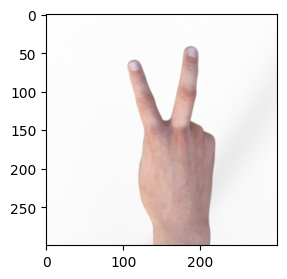

In [39]:
plt.figure(figsize=(3, 3))

plt.imshow(test_image0)
print(CLASS_NAMES[test_label0])

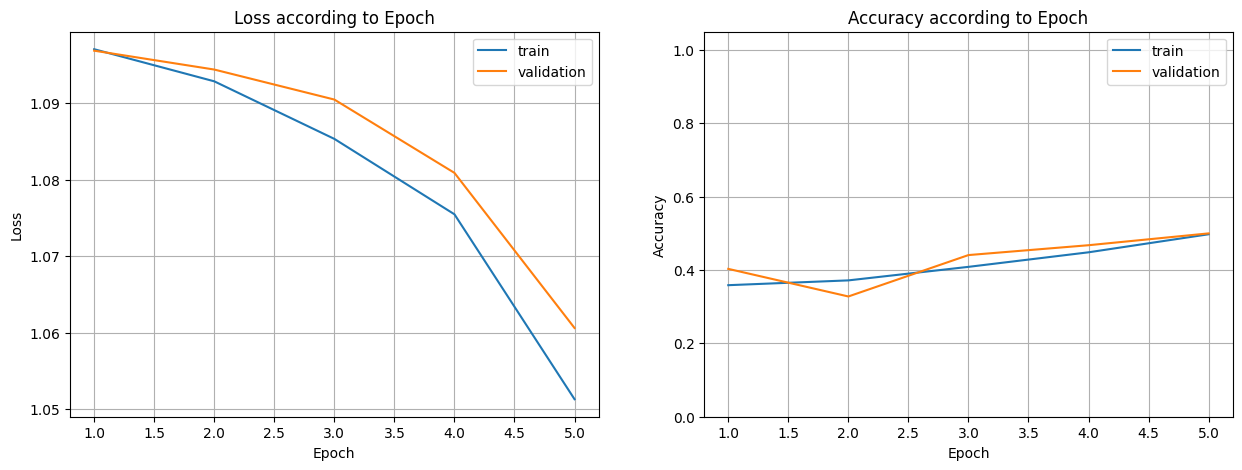

In [40]:
import pandas as pd

df_hist = pd.DataFrame(history.history)
df_hist['epoch'] = range(1, EPOCHS+1)

plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.title('Loss according to Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(df_hist['epoch'], df_hist['loss'], label='train')
plt.plot(df_hist['epoch'], df_hist['val_loss'], label = 'validation')
# plt.ylim([0, 1.5])
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy according to Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(df_hist['epoch'], df_hist['accuracy'], label='train')
plt.plot(df_hist['epoch'], df_hist['val_accuracy'], label='validation')
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()

plt.show()